<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/auction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
!pip install catboost

In [ ]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic


from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMClassifier

import joblib
import pickle

In [ ]:
!gdown --id 1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU

Downloading...
From: https://drive.google.com/uc?id=1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU
To: /content/purchase_plans.csv
5.03MB [00:00, 44.2MB/s]


#Обработка данных

Считывание данных о заявках

In [ ]:
contract_path = 'purchase_plans.csv'
dtypes = {'plan_number' : 'category', 
          'positionNumber' : 'category', 
          'customer_legal_form' : 'category', 
          'KTRU' : 'category',
          'publicDiscussion' : 'category',
          'isEnergyServiceContract': 'category'}
data = pd.read_csv(contract_path, dtype = dtypes)
gc.collect()
data.head()

,plan_number,customer_legal_form,positionNumber,KTRU,positionCanceled,publicDiscussion,total,isEnergyServiceContract,time
0,201801133000253003,75404,201801133000253003000150,95.12.10.000-00000001,False,false,97522.23,False,44
1,201901132000006001,75204,201901132000006001000054,19.20.21.125-00001,False,false,959718.96,False,365
2,201903133000826001,75403,201903133000826002000005,35.13.10.000-00000001,False,false,844422.00,False,1096
3,201903133001390001,75403,201903133001390001000004,35.30.10.000-00000004,False,false,211494.36,False,365
4,201903133001417001,75404,201903133001417001000004,61.10.11.110-00000002,False,false,7000.00,False,365


In [ ]:
num_var = ['total', 'time']
cat_var = ['plan_number', 
          'positionNumber', 
          'customer_legal_form', 
          'KTRU',
          'publicDiscussion',
          'isEnergyServiceContract']

#Анализ

In [ ]:
data.corr()

,total,time
total,1.000000,0.026131
time,0.026131,1.000000


Описание цены

In [ ]:
data['total'].describe()

count    4.920400e+04
mean     3.033807e+06
std      1.161167e+08
min      1.000000e-02
25%      2.800000e+04
50%      8.756000e+04
75%      2.999925e+05
max      7.154803e+09
Name: total, dtype: float64

In [ ]:
# Мода, медиана, среднее
result = {'mode': [], 'median': [], 'mean': []}
for nv in num_var:
    result['mode'].append(int(data[nv].mode()[0]))
    result['median'].append(int(data[nv].median()))
    result['mean'].append(int(data[nv].mean()))

result = pd.DataFrame(result, index=num_var)
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
total,50000,87560,3033806
time,365,258,255


In [ ]:
OKOPF = {
    '10000' : 'Юридические лица - коммерческие корпоративные организации',
    '11000' : 'Хозяйственные товарищества',
    '11051' : 'Полные товарищества',
    '11064' : 'Товарищества на вере (коммандитные товарищества)',
    '12000' : 'Хозяйственные общества',
    '12200' : 'Акционерные общества',
    '12247' : 'Публичные акционерные общества',
    '12267' : 'Непубличные акционерные общества',
    '12300' : 'Общества с ограниченной ответственностью',
    '13000' : 'Хозяйственные партнерства',
    '14000' : 'Производственные кооперативы (артели)',
    '14100' : 'Сельскохозяйственные производственные кооперативы',
    '14153' : 'Сельскохозяйственные артели (колхозы)',
    '14154' : 'Рыболовецкие артели (колхозы)',
    '14155' : 'Кооперативные хозяйства (коопхозы)',
    '14200' : 'Производственные кооперативы',
    '15300' : 'Крестьянские (фермерские) хозяйства',
    '19000' : 'Юридические лица - прочие коммерческие организации',
    '20000' : 'Юридические лица - некоммерческие корпоративные организации',
    '20100' : 'Потребительские кооперативы',
    '20101' : 'Гаражные и гаражно-строительные кооперативы',
    '20102' : 'Жилищные или жилищно-строительные кооперативы',
    '20103' : 'Жилищные накопительные кооперативы',
    '20104' : 'Кредитные потребительские кооперативы',
    '20105' : 'Кредитные потребительские кооперативы граждан',
    '20106' : 'Кредитные кооперативы второго уровня',
    '20107' : 'Потребительские общества',
    '20108' : 'Общества взаимного страхования',
    '20109' : 'Сельскохозяйственные потребительские перерабатывающие кооперативы',
    '20110' : 'Сельскохозяйственные потребительские сбытовые (торговые) кооперативы',
    '20111' : 'Сельскохозяйственные потребительские обслуживающие кооперативы',
    '20112' : 'Сельскохозяйственные потребительские снабженческие кооперативы',
    '20113' : 'Объединения фермерских хозяйств',
    '20115' : 'Сельскохозяйственные потребительские животноводческие кооперативы',
    '20121' : 'Фонды проката',
    '20200' : 'Общественные организации',
    '20201' : 'Политические партии',
    '20202' : 'Профсоюзные организации',
    '20210' : 'Общественные движения',
    '20211' : 'Органы общественной самодеятельности',
    '20217' : 'Территориальные общественные самоуправления',
    '20600' : 'Ассоциации (союзы)',
    '20601' : 'Ассоциации (союзы) экономического взаимодействия субъектов Российской Федерации',
    '20603' : 'Советы муниципальных образований субъектов РФ',
    '20604' : 'Союзы (ассоциации) кредитных кооперативов',
    '20605' : 'Союзы (ассоциации) кооперативов',
    '20606' : 'Союзы (ассоциации) общественных объединений',
    '20608' : 'Союзы потребительских обществ',
    '20609' : 'Адвокатские палаты',
    '20610' : 'Нотариальные палаты',
    '20611' : 'Торгово-промышленные палаты',
    '20612' : 'Объединения работодателей',
    '20613' : 'Объединения фермерских хозяйств',
    '20614' : 'Некоммерческие партнерства',
    '20615' : 'Адвокатские бюро',
    '20616' : 'Коллегии адвокатов',
    '20619' : 'Саморегулируемые организации',
    '20620' : 'Объединения (ассоциации и союзы) благотворительных организаций',
    '20700' : 'Товарищества собственников недвижимости',
    '20702' : 'Садоводческие или огороднические некоммерческие товарищества',
    '20716' : 'Товарищества собственников жилья',
    '20900' : 'Учреждения',
    '21100' : 'Казачьи общества',
    '21200' : 'Общины коренных малочисленных народов РФ',
    '30000' : 'Организации без прав юридического лица',
    '30001' : 'Представительства юридических лиц',
    '30002' : 'Филиалы юридических лиц',
    '30003' : 'Обособленные подразделения юридических лиц',
    '30004' : 'Структурные подразделения обособленных подразделений юридических лиц',
    '30005' : 'Паевые инвестиционные фонды',
    '30006' : 'Простые товарищества',
    '30008' : 'Районные суды, городские суды, межрайонные суды (районные суды)',
    '40000' : 'Международные организации на территории РФ',
    '40001' : 'Межправительственные международные организации',
    '40002' : 'Неправительственные международные организации',
    '50000' : 'Физическое лицо',
    '50100' : 'Организационно-правовые формы для коммерческой деятельности граждан',
    '50101' : 'Главы крестьянских (фермерских) хозяйств',
    '50102' : 'Индивидуальные предприниматели',
    '50200' : 'Организационно-правовые формы для деятельности граждан, не отнесенной к предпринимательству',
    '50201' : 'Адвокаты, учредившие адвокатский кабинет',
    '50202' : 'Нотариусы, занимающиеся частной практикой',
    '60000' : 'Юридические лица - коммерческие унитарные организации',
    '65000' : 'Унитарные предприятия',
    '65100' : 'Казенные предприятия',
    '65141' : 'Федеральные казенные предприятия',
    '65142' : 'Казенные предприятия субъектов РФ',
    '65143' : 'Муниципальные казенные предприятия',
    '65200' : 'Унитарные предприятия, основанные на праве хозяйственного ведения',
    '65241' : 'Федеральные государственные унитарные предприятия',
    '65242' : 'Государственные унитарные предприятия субъектов РФ',
    '65243' : 'Муниципальные унитарные предприятия',
    '70000' : 'Юридические лица - некоммерческие унитарные организации',
    '70400' : 'Фонды',
    '70401' : 'Благотворительные фонды',
    '70402' : 'Негосударственные пенсионные фонды',
    '70403' : 'Общественные фонды',
    '70404' : 'Экологические фонды',
    '71400' : 'Автономные некоммерческие организации',
    '71500' : 'Религиозные организации',
    '71600' : 'Публично-правовые компании',
    '71601' : 'Государственные корпорации',
    '71602' : 'Государственные компании',
    '71610' : 'Отделения иностранных некоммерческих неправительственных организаций',
    '75000' : 'Учреждения',
    '75100' : 'Учреждения, созданные Российской Федерацией',
    '75101' : 'Федеральные государственные автономные учреждения',
    '75103' : 'Федеральные государственные бюджетные учреждения',
    '75104' : 'Федеральные государственные казенные учреждения',
    '75200' : 'Учреждения, созданные субъектом РФ',
    '75201' : 'Государственные автономные учреждения субъектов РФ',
    '75203' : 'Государственные бюджетные учреждения субъектов РФ',
    '75204' : 'Государственные казенные учреждения субъектов РФ',
    '75300' : 'Государственные академии наук',
    '75400' : 'Муниципальные учреждения',
    '75401' : 'Муниципальные автономные учреждения',
    '75403' : 'Муниципальные бюджетные учреждения',
    '75404' : 'Муниципальные казенные учреждения',
    '75500' : 'Частные учреждения',
    '75502' : 'Благотворительные учреждения',
    '75505' : 'Общественные учреждения',
}

In [ ]:
def OKOPF_sub(x):
  return f"({x}) {OKOPF[x]}"

10251

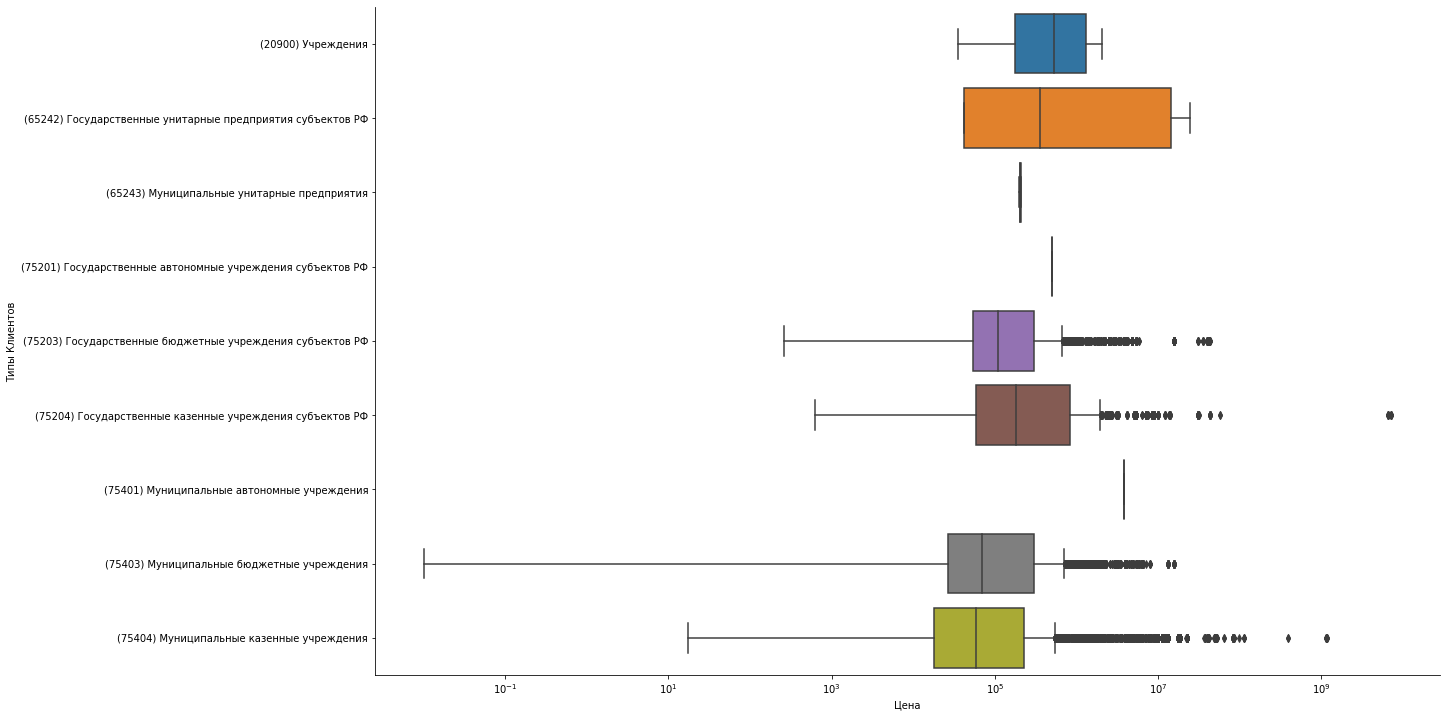

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'total'], axis=1).sort_values('customer_legal_form')
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'Типы Клиентов')
  
del data_to_plot
del g
gc.collect()

Цена и продолжительность

9889

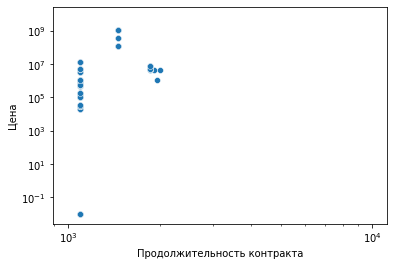

In [ ]:
g = sbs.scatterplot(x = 'time', y = 'total', data = data)
g.set(xscale = 'log', yscale = 'log', xlabel = 'Продолжительность контракта', ylabel = 'Цена')

del g
gc.collect()

1975

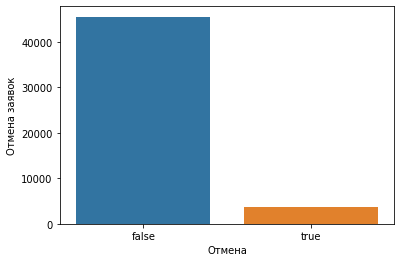

In [ ]:
g = sbs.countplot(x = 'positionCanceled', data = data)
g.set(xlabel = 'Отмена', ylabel = 'Отмена заявок')

del g
gc.collect()

Время и отмена

2058

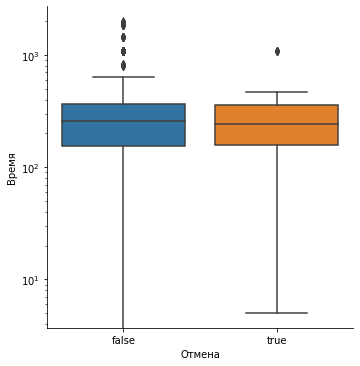

In [ ]:
g = sbs.catplot(x = 'positionCanceled', y = 'time', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Отмена', ylabel = 'Время')

del g
gc.collect()

Цена и отмена

8479

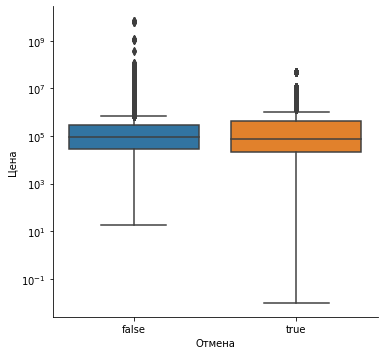

In [ ]:
g = sbs.catplot(x = 'positionCanceled', y = 'total', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Отмена', ylabel = 'Цена')

del g
gc.collect()

#Прогноз цены

In [ ]:
def errors(model, x_test, y_test):
  outputs = model.predict(x_test)
  error = np.absolute(outputs - y_test)
  mae = np.sum(error) / len(error)
  error = (outputs - y_test)**2
  mse = np.sum(error) / len(error)
  print("R2:", metrics.r2_score(outputs, y_test))
  print("MAE:", mae) #абсолютная ошибка (MAE)
  print("MSE:", mse) #среднеквадратичная ошибка (MSE)
  print("RMSE:", np.sqrt(mse)) #корень среднеквадратичной ошибки (RMSE)

In [ ]:
x = data.drop(['positionCanceled', 'total'], axis=1)
y = data['total']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [ ]:
cat_features = cat_var
model_catboost = CatBoostRegressor(
    n_estimators = 100,
    learning_rate = 0.01,
    max_depth = 4,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
errors(model_catboost, x_test, y_test)

R2: -30.23819053711597
MAE: 2600753.2722187876
MSE: 9160451642778.756
RMSE: 3026623.802651852


In [ ]:
enc = LabelEncoder()
for param in cat_var:
  x_train[param] = enc.fit_transform(x_train[param])
  x_test[param] = enc.fit_transform(x_test[param])
x_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,customer_legal_form,publicDiscussion,isEnergyServiceContract,time
0,7,0,0,44
1,4,0,0,365
2,6,0,0,1096
3,6,0,0,365
4,7,0,0,365


In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

gc.collect()

3342

In [ ]:
#стандартизация
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)
y_train = preprocessing.scale(y_train)
y_test = preprocessing.scale(y_test)
#нормализация
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)
y_train = preprocessing.normalize(y_train)
y_test = preprocessing.normalize(y_test)

In [ ]:
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
errors(lin_model, x_test, y_test)

R2: -45.788396549361195
MAE: 0.2760822864800325
MSE: 0.45573227600091454
RMSE: 0.6750794590275389


In [ ]:
poly_model = LinearRegression()
polynomial_features= PolynomialFeatures(degree=3)
x_train_poly = polynomial_features.fit_transform(x_train)
x_test_poly = polynomial_features.fit_transform(x_test)
poly_model.fit(x_train_poly, y_train)
errors(poly_model, x_test_poly, y_test)

R2: -2.2189595657406853
MAE: 700.7733970124988
MSE: 712272.1739660604
RMSE: 843.962187521491


In [ ]:
model = XGBRegressor(seed=42,
                      n_estimators=1000,
                      max_depth=10,
                      learning_rate=0.01,
                      task_type="GPU",
                      devices='0:1',)
model.fit(x_train, y_train.ravel())
errors(model, x_test, y_test.ravel())

[13:23:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: -1.4344240286799472
MAE: 1.1257751173343664
MSE: 2.145310038995021
RMSE: 1.4646876933309096


In [ ]:
#значимость признаков для леса
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
col = ['plan_number',	'customer_legal_form',	'positionNumber',	'KTRU',	'publicDiscussion',	'isEnergyServiceContract',	'time']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.3324, 'positionNumber'],
 [0.1628, 'customer_legal_form'],
 [0.161, 'time'],
 [0.1478, 'KTRU'],
 [0.1312, 'publicDiscussion'],
 [0.055, 'plan_number'],
 [0.0097, 'isEnergyServiceContract']]

In [ ]:
batch_size = 100
epochs = 100
learning_rate = 0.01

loss = "mean_squared_error"
optimizer = optimizers.SGD(lr = learning_rate)

In [ ]:
model = Sequential()
model.add(Dense(units = 100, activation = "sigmoid", input_dim=7, use_bias=True))
model.add(Dense(units = 100, activation = "sigmoid", use_bias=True))
model.add(Dense(units = 100, activation = "sigmoid", use_bias=True))
model.add(Dense(units = 100, activation = "sigmoid", use_bias=True))
model.add(Dense(units = 1,  activation = "sigmoid"))

model.compile(loss = loss,
              optimizer = optimizer,
              metrics = ["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 31,201
Trainable params: 31,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (x_test,y_test),
                    callbacks=None)

score = model.evaluate(x_test,y_test,verbose = 1)
print("test loss:",score[0])
print("test accuracy:",score[1])

Text(0, 0.5, 'loss')

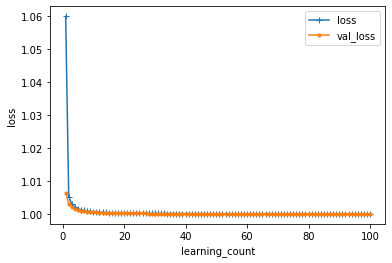

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

learning_count = len(loss)+1

plt.plot(range(1,learning_count),loss,marker = "+",label = "loss")
plt.plot(range(1,learning_count),val_loss,marker = ".",label = "val_loss")
plt.legend(loc = "best",fontsize = 10)
plt.xlabel("learning_count")
plt.ylabel("loss")

Text(0, 0.5, 'acc')

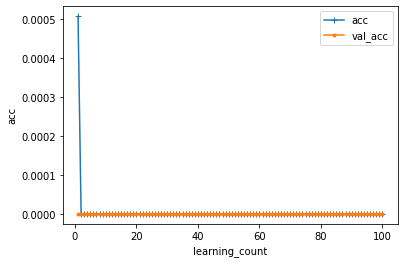

In [ ]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]

learning_count = len(loss)+1

plt.plot(range(1,learning_count),loss,marker = "+",label = "acc")
plt.plot(range(1,learning_count),val_loss,marker = ".",label = "val_acc")
plt.legend(loc = "best",fontsize = 10)
plt.xlabel("learning_count")
plt.ylabel("acc")

#Прогноз отмены

In [ ]:
print('True', len(y_train[y_train == True].index))
print('False', len(y_train[y_train == False].index))

True 3563
False 35800


In [ ]:
print('True', len(y_test[y_test == True].index))
print('False', len(y_test[y_test == False].index))

True 108
False 9733


In [143]:
x = data.drop(['positionCanceled', 'total'], axis=1)
y = data['positionCanceled']

In [144]:
y = LabelEncoder().fit_transform(y)

In [145]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

Streaming output truncated to the last 5000 lines.
163:	learn: 0.0589108	total: 1.67s	remaining: 874ms
164:	learn: 0.0587823	total: 1.68s	remaining: 863ms
165:	learn: 0.0586573	total: 1.68s	remaining: 853ms
166:	learn: 0.0585502	total: 1.69s	remaining: 842ms
167:	learn: 0.0584816	total: 1.7s	remaining: 831ms
168:	learn: 0.0582489	total: 1.71s	remaining: 821ms
169:	learn: 0.0581760	total: 1.72s	remaining: 810ms
170:	learn: 0.0581286	total: 1.73s	remaining: 799ms
171:	learn: 0.0580701	total: 1.74s	remaining: 789ms
172:	learn: 0.0579606	total: 1.75s	remaining: 778ms
173:	learn: 0.0578749	total: 1.76s	remaining: 768ms
174:	learn: 0.0577196	total: 1.77s	remaining: 758ms
175:	learn: 0.0576662	total: 1.78s	remaining: 747ms
176:	learn: 0.0574778	total: 1.79s	remaining: 737ms
177:	learn: 0.0572828	total: 1.8s	remaining: 727ms
178:	learn: 0.0572375	total: 1.81s	remaining: 716ms
179:	learn: 0.0570650	total: 1.81s	remaining: 706ms
180:	learn: 0.0570201	total: 1.82s	remaining: 696ms
181:	learn: 0.0

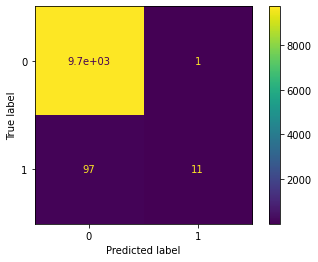

In [147]:
%%time
cat_features = cat_var

parameters = {
    "n_estimators": [150, 250, 200],
    "learning_rate": [0.03, 0.02, 0.01],
    "max_depth": [1,2,3],
}

model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(x_train, y_train)

print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)

y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['False', 'True']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

del y_pred
gc.collect()

In [148]:
model_catboost.best_estimator_.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/auction/catboost(isCanseled)")

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      9733
        True       0.92      0.10      0.18       108

    accuracy                           0.99      9841
   macro avg       0.95      0.55      0.59      9841
weighted avg       0.99      0.99      0.99      9841



374

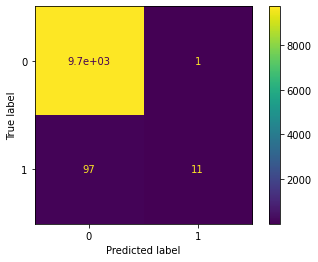

In [ ]:
cat_features = cat_var
model_catboost = CatBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.01,
    max_depth = 4,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['False', 'True']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

del y_pred
gc.collect()

In [ ]:
#значимость признаков для леса
importances = model_catboost.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['plan_number',	'customer_legal_form',	'positionNumber',	'KTRU',	'publicDiscussion',	'isEnergyServiceContract',	'time']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[96.756, 'positionNumber'],
 [1.7534, 'KTRU'],
 [1.0974, 'plan_number'],
 [0.2612, 'customer_legal_form'],
 [0.0978, 'time'],
 [0.0236, 'publicDiscussion'],
 [0.0106, 'isEnergyServiceContract']]

In [ ]:
model_catboost.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/auction/catboost(isCanseled)")

In [ ]:
enc = LabelEncoder()
for param in cat_var:
  x_train[param] = enc.fit_transform(x_train[param])
  x_test[param] = enc.fit_transform(x_test[param])
x_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,plan_number,customer_legal_form,positionNumber,KTRU,publicDiscussion,isEnergyServiceContract,time
0,0,7,0,407,0,0,44
1,4,4,12,80,0,0,365
2,412,6,1331,218,0,0,1096
3,569,6,1901,225,0,0,365
4,573,7,1910,304,0,0,365


              precision    recall  f1-score   support

       False       0.99      1.00      0.99      9733
        True       0.00      0.00      0.00       108

    accuracy                           0.99      9841
   macro avg       0.49      0.50      0.50      9841
weighted avg       0.98      0.99      0.98      9841



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3837

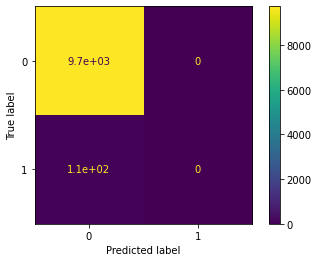

In [ ]:
model = XGBClassifier(seed=42,
                      n_estimators=1000,
                      max_depth=10,
                      learning_rate=0.01,
                      task_type="GPU",
                      devices='0:1',)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['False', 'True']))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

del y_pred
gc.collect()

In [ ]:
#значимость признаков для леса
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
col = ['plan_number',	'customer_legal_form',	'positionNumber',	'KTRU',	'publicDiscussion',	'isEnergyServiceContract',	'time']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.3749, 'customer_legal_form'],
 [0.2017, 'KTRU'],
 [0.1317, 'positionNumber'],
 [0.1103, 'isEnergyServiceContract'],
 [0.091, 'time'],
 [0.0903, 'plan_number'],
 [0.0, 'publicDiscussion']]